# FYP: Lightweight Deep Learning for Deep Fake Detection

In [850]:
import os
import gc
import torch
import datetime
import torch.nn as nn
import torch_pruning as tp

from effnet import *
from effnet import phi_values, EfficientNet

# use GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: %s" % device)

Using device: cuda


#### Utilities

In [851]:
# clean-up unused GPU memory
def cleanup():
    # garbage collector
    gc.collect()

    # clear pytorch cache
    with torch.no_grad():
        torch.cuda.empty_cache()

In [852]:
# if model to be save/loaded is PRUNED, the saving/loading must be handled differently.
# model file/directory path must be named accordingly to include the word "pruned" to denote a pruned model

# save model state
def save_model_state(model, PATH, is_pruned = False):
    if "pruned" in PATH.lower() or is_pruned:
        torch.save(tp.state_dict(model), PATH)
    else:
        torch.save(model.state_dict(), PATH)

# load model from saved state
def load_model_state(model, PATH, is_pruned = False):

    if "pruned" in PATH.lower() or is_pruned:
        tp.load_state_dict(model, torch.load(PATH, map_location = torch.device('cpu')))
        
    else:
        model.load_state_dict(torch.load(PATH, map_location = torch.device('cpu')))

    model = model.to(device)
    return model

In [853]:
def print_size_of_model(model):
    """ Prints the real size of the model """
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

## Part 1: Settings

### Run-time settings

In [854]:
# turn off these settings for convenience (i.e. avoid reruns)

# perform data loading/preprocessing
LOAD_DATA = input("LOAD DATA?")

# set current run as test only (nullifies training settings and load test data only)
TESTING_MODE = True

# create a new model
NEW_MODEL = True

# set to false to avoid re-training/finetuning
TRAIN = False

In [855]:
# If true, model will halt training if validation loss does not improve within patience window
EARLYSTOP = True

# If true, model will use pretrained weights if available
PRETRAINED = True

# apply learning algo for finetuning instead of regular training
FINETUNE = True

# If true, model will undergo pruning
PRUNE = True

# Knowledge Distillation - specify a teacher model to teach loss to the current model
KD = False

# Quantize a model
QUANTIZE = False

# Quantization Aware Training
QAT = False

# model loaded is QUANTIZED - will crash kernel if summary applied to quantized models
IS_QUANTIZED = False

In [856]:
# if we are TESTING, silence all training runtime settings
if TESTING_MODE:
    TRAIN = False
    NEW_MODEL = False
    PRUNE = False
    QUANTIZE = False
    KD = False

### Model name and file path

In [857]:
# reset PATH
PATH = None

if NEW_MODEL:
    # by default will save current datetime
    current_datetime = datetime.datetime.now()
    formatted_datetime = current_datetime.strftime("%m-%d %H%MH")

    model_name = input("Name your model: ")

    if not model_name: model_name = "model (%s)" %formatted_datetime

    PATH = 'C:/Users/chuag/OneDrive - Nanyang Technological University/Desktop/BCG 4.2/FYP/code/models/%s.pth' %model_name
    

# To skip loading a model, just hit ENTER or ESC
LOAD_MODEL_PATH = input("Enter path of model to LOAD: ")

print(PATH)
print(LOAD_MODEL_PATH)

None
models\LITE0-35pruned-5iter-FT.pth


### Model Selection

In [858]:
# choice (a) use own implementation
# choice (b) use pytorch's official implementation
# choice (c) use TIMM's efficientnet with knapsack pruning
# choice (d) use OWN efficientnet lite
# choice (e) use pretrained efficientnet lite
# choice (f) use efficientnet lite archi that supports quantization but have it disable for trg
# choice (g) use quantization enabled efficientnet lite

a = "USE OWN"
b = "pytorch-effnet"
c = "TIMM effnet"
d = "OWN effnet-lite"
e = "pretrained lite"
f = "quantized-disabled effnet-lite"
g = "quantized-enabled effnet-lite"

#########
USE = e
#########


### Optimizer & Scheduler Selection

In [859]:
# Choice of optimizers
o1 = "RMSPROP"
o2 = "ADAM"
o3 = "SGD"

##############
USE_OPTIM = o3
##############

# Choice of learning schedulers
s0 = None
s1 = "STEPLR"
s2 = "PLATEAU"
s3 = "COSINE"
s4 = "COSRES"

############
USE_SCH = s3
############

### Hyperparameters & Training settings

In [860]:
# learning rate - recommended: 0.001 for b0 and 0.0001 for b2
lr = 0.0005

# Weight Decay - paper used 1e-05
wd = 1e-05

# effnet version to use
version = 0

# number of training epochs (recommended: 50 - 200)
num_epochs = 30

# early stopping patience - recommended: 5 (15 when doing cosine scheduling w/ restarts)
patience = 5

# 32 is pretty much the highest we can go with current hardware
batch_size = 32

# linear warm-up (no. epochs) -> set to 0 for training with no warm-up
warmup_period = 10

# If using cosine annealing with warm restarts, choose number of iterations before restart
restart_period = 10

### Fine Tuning settings

In [861]:
# Custom settings for fine-tuning pretrained models
if FINETUNE:
    num_epochs = 20
    patience = 3
    lr = 2e-04
    wd = 1e-05
    USE_OPTIM = o2
    USE_SCH = s0
    warmup_period = 0
    # EARLYSTOP = False

### Pruning settings

In [862]:
# pruning settings
pruning_ratio = 0.05
pruning_iters = 1
global_pruning = False
pruning_criterion = "Taylor"
finetune_aft_prune = False

### Knowledge Distillation settings

In [863]:
# KD settings

# soft label weight
soft_label_weight = 0.25

# binary cross entropy loss weight
hard_label_weight = 1 - soft_label_weight

# path of teacher model
TEACHER_PATH = "models\B0-FF-FT.pth"

# specify the teacher's model type for correct loading
TEACHER_USE = b

### Data selection & distribution

In [864]:
FF_PATH = "C:/Users/chuag/OneDrive - Nanyang Technological University/Desktop/BCG 4.2/FYP/code/data/FF++/processed/c23"
DFDC_PATH = "C:/Users/chuag/OneDrive - Nanyang Technological University/Desktop/BCG 4.2/FYP/code/data/DFDC"

categories = ["DFDC", "DeepFakeDetection", "Deepfakes", "Face2Face", "FaceShifter", "FaceSwap", "NeuralTextures", "youtube", "actors"]

if not TESTING_MODE:
    ## for training
    dataset = {"DFDC": (0, 0), # no. real | no. fake
        "DeepFakeDetection": 0,
        "Deepfakes": 3000,
        "Face2Face": 3000,
        "FaceShifter": 3000,
        "FaceSwap": 3000,
        "NeuralTextures": 3000,
        "youtube": 10000,
        "actors": 0}
    test_size = 0.15
    valid_size = 0.15

else:
    ## for testing
    dataset = {"DFDC": (0, 0), # no. real | no. fake
            "DeepFakeDetection": 0,
            "Deepfakes": 100,
            "Face2Face": 100,
            "FaceShifter": 100,
            "FaceSwap": 100,
            "NeuralTextures": 100,
            "youtube": 500,
            "actors": 0}
    test_size = 1
    valid_size = 0



### Binary Classification Problem Formulation

In [865]:
# binary classification
num_classes = 1
classes = ["real", "fake"]

# loss fn
criterion = nn.BCEWithLogitsLoss()

## Part 2: Initialization

### Model blueprints

In [866]:
# efficientnet's model scaling variables
phi, res, dropout = phi_values[f"b{version}"]

# resolution: input tensor size = SIZE * SIZE
SIZE = res

In [867]:
efficientnet = getattr(__import__("torchvision.models", fromlist=[f"efficientnet_b{version}"]), f"efficientnet_b{version}")
 
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

from torchvision.ops.misc import SqueezeExcitation

import timm
from efficientnet_lite import build_efficientnet_lite
from effnet_liteQ import build_effnetliteQ

# code to patch a pytorch effnet bug
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

def pytorch_effnet(num_classes, pretrained = False):
    if pretrained:
        model = efficientnet(weights = 'IMAGENET1K_V1')
    else:
        model = efficientnet()
    in_feats = model.classifier[1].in_features
    dropout = model.classifier[0].p
    model.classifier = nn.Sequential(nn.Dropout(dropout, inplace = True),
                                     nn.Linear(in_features=in_feats,
                                     out_features=num_classes, bias=True))

    for param in model.children():
        param.requires_grad_(True)

    model = model.to(device)
    return model

def timm_effnet(version, num_classes, pretrained = True):
    model = timm.create_model(f'efficientnet_b{version}_pruned', pretrained = pretrained, num_classes = num_classes)
    for param in model.children():
        param.requires_grad_(True)
    
    model = model.to(device)

    return model

### Model Changes: EfficientNet-Lite
def make_lite(model):

    # recursively changes SiLUs into ReLUs
    def replace_silu(model):
        for name, child in model.named_children():
            if isinstance(child, nn.SiLU):
                setattr(model, name, nn.ReLU6())
            else:
                replace_silu(child)

    replace_silu(model)

    # removing SqueezeExcitation layers
    def remove_se_layers(model):
        for name, child in model.named_children():
            if isinstance(child, SqueezeExcitation):
                setattr(model, name, nn.Identity())
            else:
                remove_se_layers(child)

    remove_se_layers(model)

    return model

def effnet_lite(num_classes, pretrained = True):
    model_name = f'efficientnet_lite{version}'
    model = build_efficientnet_lite(model_name, 1000)

    if pretrained:
        model.load_state_dict(torch.load(f"models\{model_name}.pth", map_location = torch.device('cpu')))

    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_features = in_feats, out_features = num_classes)

    for param in model.children():
        param.requires_grad_(True)

    model = model.to(device)
    return model

def effnet_liteQ(num_classes, pretrained = True, q = True):
    model_name = f'efficientnet_lite{version}'
    model = build_effnetliteQ(model_name, 1000, q = q)

    if pretrained:
        model.load_state_dict(torch.load(f"models\{model_name}.pth", map_location = torch.device('cpu')))

    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_features = in_feats, out_features = num_classes)

    for param in model.children():
        param.requires_grad_(True)

    model = model.to(device)
    return model


### Create/Load a model

In [868]:
if NEW_MODEL or LOAD_MODEL_PATH:

    if USE == a:
        model = EfficientNet(version = version, num_classes = num_classes).to(device)

    elif USE == b:
        model = pytorch_effnet(num_classes, pretrained = PRETRAINED)

    elif USE == c:
        model = timm_effnet(version = version, num_classes = num_classes, pretrained=PRETRAINED)

    elif USE == d:
        model = pytorch_effnet(num_classes, pretrained = PRETRAINED)
        model = make_lite(model)

    elif USE == e:
        model = effnet_lite(num_classes=num_classes, pretrained=PRETRAINED)

    elif USE == f:
        model = effnet_liteQ(num_classes=num_classes, pretrained=PRETRAINED, q = False)

    elif USE == g:
        model = effnet_liteQ(num_classes=num_classes, pretrained=PRETRAINED, q = True)
    
    if LOAD_MODEL_PATH:
        
        model = load_model_state(model, LOAD_MODEL_PATH)

### Load the teacher model

In [869]:
if KD:

    if TEACHER_USE == a:
        teacher = EfficientNet(version = version, num_classes = num_classes).to(device)

    elif TEACHER_USE == b:
        teacher = pytorch_effnet(num_classes, pretrained = PRETRAINED)

    elif TEACHER_USE == c:
        teacher = timm_effnet(version = version, num_classes = num_classes, pretrained=PRETRAINED)

    elif TEACHER_USE == d:
        teacher = pytorch_effnet(num_classes, pretrained = PRETRAINED)
        teacher = make_lite(teacher)

    elif TEACHER_USE == e:
        teacher = effnet_lite(num_classes=num_classes, pretrained=PRETRAINED)

    elif TEACHER_USE == f:
        teacher = effnet_liteQ(num_classes=num_classes, pretrained=PRETRAINED, q = False)

    elif TEACHER_USE == g:
        teacher = effnet_liteQ(num_classes=num_classes, pretrained=PRETRAINED, q = True)
        
    
    teacher = load_model_state(teacher, TEACHER_PATH)

else:
    teacher = None

### Model Weight Initializations

In [870]:
# for name, param in model.named_parameters():
#     print(name, param)
#     break

def init_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.xavier_uniform_(module.weight)
        return module
    
    else:
        return module
    
if NEW_MODEL and not PRETRAINED:
    model = model.apply(init_weights)

### Optimizers

In [871]:
## Optimizers ##
import torch.optim as optim
'''
Effnet Paper's setting (for batch size 4096)
# optimizer = optim.RMSprop(model.parameters(), weight_decay = 1e-05, alpha=0.9, lr = 0.256, momentum = 0.9)
'''

## RMSPROP Optimizer
if USE_OPTIM == o1:
    optimizer = optim.RMSprop(model.parameters(), weight_decay = lr, alpha=0.9999, lr = 0.002, momentum = 0.9)

## ADAM Optimizer
elif USE_OPTIM == o2:
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

## SGD Optimizer
elif USE_OPTIM == o3:
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)


### Learning Rate Schedulers

In [872]:
## Schedulers ##
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts

## Effnet Paper's setting (for batch size 4096)
# scheduler = StepLR(optimizer, step_size=2.4, gamma=0.97)

scheduler_input = False # does the scheduler require valid_loss for each step as input?
scheduler = None # use no scheduler by default
step_epoch = True # let the scheduler step at epoch (True) or mini-batch (False)?

## STEPPER Scheduler
if USE_SCH == s1:
    scheduler = StepLR(optimizer, step_size=1, gamma=0.97)

## PLATEAU Scheduler
elif USE_SCH == s2:
    scheduler_input = True # requires valid loss
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)

## COSINE Annealing
elif USE_SCH == s3:
    scheduler = CosineAnnealingLR(optimizer, num_epochs - warmup_period)

## COSINE Annealing with Warm Restarts
elif USE_SCH == s4:
    # NOTE: scheduler takes next step over each mini-batch instead of epoch
    # REFER: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html

    step_epoch = False # update by mini-batch
    scheduler_input = True # requires to step a fraction of the current epoch number (divide by batch size)
    scheduler = CosineAnnealingWarmRestarts(optimizer, restart_period)


### Implement Linear Warm-up

In [873]:
import pytorch_warmup as warmup

if warmup_period > 0:
    ## Using Linear Warm up
    '''
    If you want to start the learning rate schedule after the end of the linear warmup,
    delay it by the warmup period:

        with warmup_scheduler.dampening():
            if warmup_scheduler.last_step + 1 >= warmup_period:
                lr_scheduler.step()
    '''
    warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)

else:
    warmup_scheduler = None
    

## Part 3: Deep Fake Data Loading and Processing

In [874]:
# Step 1. Read dir, get image paths for individual categories [ X ]
# Step 1a. Make new a class to store the three properties [ X ]
# Step 2. Train-test split the categories (80%-20%) [ X ]
# Step 3. Combine the train and test sets respectively [ X ]
# Step 3a. perform transforms for trainset [ X ]
# Step 3b. remember to include categorical labels for tracing [ X ]
# Step 4. Create data loader objects [ X ]

In [875]:
from PIL import Image

class frame():
  def __init__(self, imgpath, label, category, transform):
    self.imgpath = imgpath
    self.label = label
    self.cat = category

    self.X = transform(Image.open(imgpath).convert('RGB'))#.to(device) # - this will gpu memory crash for large sets

    if self.label == "fake": self.y = 1
    else: self.y = 0

  def values(self):
    return self.X, self.y, self.label, self.cat, self.imgpath

In [876]:
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split as TTS
import torchvision

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    torchvision.transforms.Resize((SIZE, SIZE), antialias = True)
    ])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((SIZE, SIZE), antialias = True)
    ])

def TTVS(indices, test_size = 0.2, valid_size = 0.1):

  # Calculate the sizes for test and validation sets
  test_size = int(test_size * len(indices))
  valid_size = int(valid_size * len(indices))

  # Divide the indices into train, test, and validation sets
  test_indices = indices[:test_size]
  valid_indices = indices[test_size:test_size + valid_size]
  train_indices = indices[test_size + valid_size:]

  return train_indices, test_indices, valid_indices


def load(ROOT, label, category, ftype, train_transform, test_transform, test_size = 0.2, valid_size = 0.1, sample = None):
  '''
  loads data according to the origin's folder structure (DFDC differs from FF++) as frame objects
  and train test split using the sampling and transform rules provided.
  '''

  if category == "DFDC": path = os.path.join(ROOT, ftype, label)
  else: path = os.path.join(ROOT, label, category, ftype)

  train_frames = []
  test_frames = []
  valid_frames = []

  dir = os.listdir(path)

  if sample: sample_size = sample
  else: sample_size = len(dir)

  indices = random.sample(range(len(dir)), sample_size)

  train_indices, test_indices, valid_indices = TTVS(indices, test_size = test_size, valid_size = valid_size)

  for i in tqdm(train_indices):
    image_name = dir[i]
    new_frame = frame(imgpath = os.path.join(path, image_name),
                      label = label,
                      category = category,
                      transform = train_transform)
    train_frames.append(new_frame)

  for i in tqdm(test_indices):
    image_name = dir[i]
    new_frame = frame(imgpath = os.path.join(path, image_name),
                      label = label,
                      category = category,
                      transform = test_transform)
    test_frames.append(new_frame)

  for i in tqdm(valid_indices):
    image_name = dir[i]
    new_frame = frame(imgpath = os.path.join(path, image_name),
                      label = label,
                      category = category,
                      transform = test_transform)
    valid_frames.append(new_frame)

  return train_frames, test_frames, valid_frames

In [877]:
if LOAD_DATA:
    training = []
    testing = []
    validation = []

In [878]:
## Deep Fake Detection Challenge (preprocessed) ##

if LOAD_DATA and dataset["DFDC"][0] > 0:
    DFDC_real_train, DFDC_real_test, DFDC_real_valid = load(DFDC_PATH, "real", "DFDC", "train", train_transform, test_transform, test_size, valid_size, dataset["DFDC"][0])
    DFDC_fake_train, DFDC_fake_test, DFDC_fake_valid = load(DFDC_PATH, "fake", "DFDC", "train", train_transform, test_transform, test_size, valid_size, dataset["DFDC"][1])

    training = training + DFDC_real_train + DFDC_fake_train
    testing = testing + DFDC_real_test + DFDC_fake_test
    validation = validation + DFDC_real_valid + DFDC_fake_valid

In [879]:
### This two datasets should go together

## ACTORS (untampered original videos of DeepFakeDetection)
if LOAD_DATA and dataset["actors"] > 0:
    ACTORS_train, ACTORS_test, ACTORS_valid = load(FF_PATH,"real","actors","faces",train_transform,test_transform,test_size,valid_size,dataset["actors"])
    
    training = training + ACTORS_train
    testing = testing  + ACTORS_test
    validation = validation + ACTORS_valid

## DeepFakeDetection dataset
if LOAD_DATA and dataset["DeepFakeDetection"] > 0:
    DFD_train, DFD_test, DFD_valid = load(FF_PATH,"fake","DeepFakeDetection","faces",train_transform,test_transform,test_size,valid_size,dataset["DeepFakeDetection"])

    training = training + DFD_train
    testing = testing + DFD_test 
    validation = validation + DFD_valid

In [880]:
## FaceForensics (untampered original videos of FF++)
if LOAD_DATA and dataset["youtube"] > 0:
    YT_train, YT_test, YT_valid = load(FF_PATH,"real","youtube","faces",train_transform,test_transform,test_size,valid_size,dataset["youtube"])

    training = training + YT_train
    testing = testing + YT_test
    validation = validation + YT_valid

In [881]:
## FF++: DeepFakes
if LOAD_DATA and dataset["Deepfakes"] > 0:
    DF_train, DF_test, DF_valid = load(FF_PATH,"fake","Deepfakes","faces",train_transform,test_transform,test_size,valid_size,dataset["Deepfakes"])

    training = training + DF_train
    testing = testing + DF_test
    validation = validation + DF_valid

In [882]:
## FF++: Face2Face
if LOAD_DATA and dataset["Face2Face"] > 0:
    F2F_train, F2F_test, F2F_valid = load(FF_PATH,"fake","Face2Face","faces",train_transform,test_transform,test_size,valid_size,dataset["Face2Face"])

    training = training + F2F_train
    testing = testing + F2F_test
    validation = validation + F2F_valid

In [883]:
## FF++: FaceShifter
if LOAD_DATA and dataset["FaceShifter"] > 0:
    SHIFTER_train, SHIFTER_test, SHIFTER_valid = load(FF_PATH,"fake","FaceShifter","faces",train_transform,test_transform,test_size,valid_size,dataset["FaceShifter"])

    training = training + SHIFTER_train
    testing = testing + SHIFTER_test
    validation = validation + SHIFTER_valid

In [884]:
## FF++: FaceSwap
if LOAD_DATA and dataset["FaceSwap"] > 0:
    SWAP_train, SWAP_test, SWAP_valid = load(FF_PATH,"fake","FaceSwap","faces",train_transform,test_transform,test_size,valid_size,dataset["FaceSwap"])

    training = training + SWAP_train
    testing = testing + SWAP_test
    validation = validation + SWAP_valid

In [885]:
## FF++: NeuralTextures
if LOAD_DATA and dataset["NeuralTextures"] > 0:
    NT_train, NT_test, NT_valid = load(FF_PATH,"fake","NeuralTextures","faces",train_transform,test_transform,test_size,valid_size,dataset["NeuralTextures"])

    training = training + NT_train
    testing = testing + NT_test
    validation = validation + NT_valid

In [886]:
random.shuffle(training)
random.shuffle(testing)
random.shuffle(validation)

In [887]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, frames):
      self.frames = frames

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        return self.frames[idx].values()

trainset = CustomDataset(training)
testset = CustomDataset(testing)
validset = CustomDataset(validation)

trainloader = DataLoader(trainset, batch_size = batch_size)
testloader = DataLoader(testset, batch_size = batch_size)
validloader = DataLoader(validset, batch_size = batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


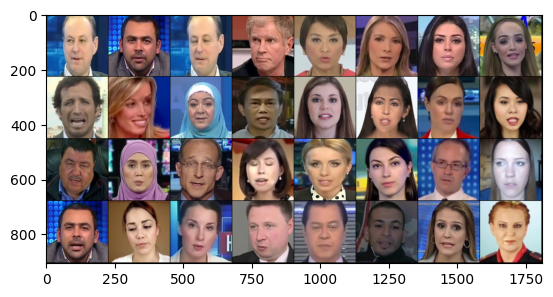

fake  fake  real  real  real  fake  real  real  real  fake  fake  fake  real  fake  fake  fake  fake  real  real  fake  fake  real  fake  real  real  real  real  real  real  real  real  fake 


In [888]:
import matplotlib.pyplot as plt
import numpy as np

if TESTING_MODE:
    showloader = testloader
else:
    showloader = trainloader

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(showloader)
X, Y, labels, cats, paths = next(dataiter)

imshow(torchvision.utils.make_grid(X[:batch_size]))

print(' '.join(f'{labels[j]:5s}' for j in range(batch_size)))

## Part 4: Training/Testing Algorithm

In [889]:
# early stopping logic
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0, model = None):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [890]:
def call_scheduler(scheduler, requires_input = False, sch_input = None):
    # STEP THE LEARNING RATE USING SCHEDULER #

    # assumes mini-batch stepping uses cosine annealing with warm restarts
    # assumes epoch stepping uses plateau

    if scheduler and requires_input:
        scheduler.step(sch_input)

    elif scheduler:
        scheduler.step()

In [891]:
from tqdm import tqdm

def train(model, criterion, optimizer, early_stop = True,
          scheduler = None, scheduler_input = False, step_epoch = True,
          warmup_scheduler = None, warmup_period = 0, QAT = False, teacher = None,
          num_epochs = 50, patience = 3, SAVE = True, savefolder = None, MODEL_PATH = None):
    '''
    inputs -
    model: model to be trained
    criterion: loss fn
    optimizer: learning optimizer
    early_stop: do early stopping
    scheduler: learning scheduler
    scheduler_input: if True: scheduler's step requires input
    step_epoch: if True: scheduler should step every epoch | if False: scheduler will step every mini-batch
    warmup_scheduler: warm up scheduler
    warmup_period: no. cycles before restart
    QAT: Perform QAT optimizations
    KD: Perform Knowledge Distillation using teacher model
    num_epochs: number of epochs to train for
    patience: early stopping patience
    SAVE: save the progress for latest epoch and best model
    savefolder: relative folder to save the model progress
    MODEL_PATH: the PATH of the model - tells us if the model is pruned or not
    '''
    earlystopper = EarlyStopper(patience=patience)
    
    # set teacher to eval mode
    if teacher:
        teacher.eval()
        KD_loss = nn.BCELoss()

    # when warmed is false, schedulers and earlystopping is inactive.
    if warmup_scheduler: warmed = False
    else: warmed = True

    # model is pruned (save/load handled differently)
    is_pruned = "pruned" in MODEL_PATH.lower()

    min_validation_loss = np.inf

    # best_model = model.state_dict()
    if SAVE: save_model_state(model, f"{savefolder}/best_model.pth", is_pruned)
    
    best_epoch = -1

    train_losses = []
    train_acc = []
    valid_losses = []
    valid_acc = []
    learning_rates = []

    for epoch in range(num_epochs):

        # training
        model.train()
        running_loss = 0.0
        iter_size = 0
        correct_train = 0
        total_train = 0

        for i, V  in enumerate(tqdm(trainloader)):
            X, Y, _, _, _ = V
            optimizer.zero_grad()
            X = X.to(device)
            Y = Y.to(device)

            # disable quantizer observers at epoch 4
            if epoch >= 3 and QAT:
              model.apply(torch.quantization.disable_observer)
            
            # disable stats computation for batch norm at epoch 3
            if epoch >= 2 and QAT:
              model.apply(torch.nn.intrinsic.qat.freeze_bn_stats)

            logits = model(X)

            # BCELoss sigmoids for you, just give it logits
            loss = criterion(logits, Y.unsqueeze(1).float())

            # if KD, let teacher model distill knowledge to student via loss matching
            if teacher:
                # forward pass teacher model but do not make weight adjustments
                with torch.no_grad():
                    teacher_logits = teacher(X)

                soft_loss = KD_loss(torch.sigmoid(logits), torch.sigmoid(teacher_logits))
                loss = soft_label_weight * soft_loss + hard_label_weight * loss

            loss.backward()
            optimizer.step()

            # prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

            running_loss += loss.item()

            out = torch.sigmoid(logits)
            pred = (out > 0.5).float()
            total_train += Y.size(0)
            results = pred.squeeze() == Y.to(device)
            correct_train += (results).sum().item()

            iter_size += 1

            if scheduler and (not step_epoch) and warmed: # used for COSINE annealing w/ warm restarts
                warmed = call_scheduler(scheduler, scheduler_input, ((epoch - warmup_period) + i / len(trainloader)))

        train_accuracy = 100 * float(correct_train / total_train)
        train_loss = running_loss/iter_size

        train_acc.append(train_accuracy)
        train_losses.append(train_loss)

        lr = optimizer.param_groups[0]['lr']
        learning_rates.append(lr)
        
        if teacher: print(f"[epoch: {epoch + 1}] loss: {train_loss:.3f} acc: {train_accuracy:.1f}% LR: {lr} KD-weight: {soft_label_weight}")
        else: print(f"[epoch: {epoch + 1}] loss: {train_loss:.3f} acc: {train_accuracy:.1f}% LR: {lr}")
        # if scheduler: print(f"Scheduler - LR: {scheduler.get_last_lr()}")
        
        # save the model every epoch to restore progress
        if SAVE: save_model_state(model, f"{savefolder}/latest_epoch.pth", is_pruned)

        # evaluation
        model.eval()

        running_loss = 0.0
        iter_size = 0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for X, Y, _, _, _ in validloader:
                X = X.to(device)
                Y = Y.to(device)
                
                logits = model(X)
                loss = criterion(logits, Y.unsqueeze(1).float())
                running_loss += loss.item()
                
                out = torch.sigmoid(logits)
                pred = (out > 0.5).float()
                total_test += Y.size(0)
                results = pred.squeeze() == Y
                correct_test += (results).sum().item()

                iter_size += 1

            valid_accuracy = 100 * float(correct_test / total_test)
            valid_loss = running_loss/iter_size
            valid_acc.append(valid_accuracy)
            valid_losses.append(valid_loss)

            print(f'validation loss: <{valid_loss:.3f}> acc: {valid_accuracy:.1f}%')

        # STEP THE LEARNING RATE USING SCHEDULER #
        if not warmed:
            with warmup_scheduler.dampening():
                if warmup_scheduler.last_step + 1 >= warmup_period:
                    warmed = True

        if scheduler and warmed and step_epoch:
            call_scheduler(scheduler, scheduler_input, valid_loss)

        # SAVE the best model seen so far #
        if valid_loss < min_validation_loss:
            min_validation_loss = valid_loss
            # best_model = model.state_dict()
            if SAVE: save_model_state(model, f"{savefolder}/best_model.pth", is_pruned)

            best_epoch = epoch + 1
            if epoch != 0: print(">>> found model improvement <<<")
        
        # EARLY STOPPING #
        if early_stop and warmed and earlystopper.early_stop(valid_loss, model):
            print("Stopping training early due to validation loss exceeding patience.")
            break

    if SAVE: # loads best model version found during training
        # torch.save(best_model, PATH)
        # model.load_state_dict(torch.load(PATH))
        
        print("Loading Best Model found at Epoch %s" % best_epoch)
        model = load_model_state(model, f"{savefolder}/best_model.pth", is_pruned)
        # model.load_state_dict(best_model)

    print('training complete')
    
    return train_losses, train_acc, valid_losses, valid_acc, learning_rates

In [892]:
import time as t
def test(model, loader, verbose = True, device = "cpu"):
  start_time = t.time()
  correct = 0
  total = 0
  categories = ["DFDC", "DeepFakeDetection", "Deepfakes", "Face2Face", "FaceShifter", "FaceSwap", "NeuralTextures", "youtube", "actors"]
  cat_correct = {cat:0 for cat in categories}
  cat_total = {cat:0 for cat in categories}

  actual = []
  predictions = []
  batch_timings = []

  def compare(cat_total, cat_correct, cats, results):
    for i, result in enumerate(results):
      if result: # if correct
        cat_correct[cats[i]] += 1
      cat_total[cats[i]] += 1

    return cat_correct, cat_total

  # since we're not training, we don't need to calculate the gradients for our outputs
  model.eval()
  with torch.no_grad():
      for data in tqdm(loader):
          X, Y, labels, cats, _ = data
          X = X.to(device)
          Y = Y.to(device)
          
          # measure batch inference speed
          batch_start_time = t.time()
          # calculate outputs by running images through the network
          logits = model(X)
          batch_end_time = t.time()

          out = torch.sigmoid(logits)
          pred = (out > 0.5).float() #binary classification: <= 0.5: 0 ; > 0.5: 1
          total += Y.size(0)
          results = pred.squeeze() == Y
          correct += (results).sum().item()
          cat_correct, cat_total = compare(cat_total, cat_correct, cats, results)

          actual += [int(x) for x in Y]
          predictions += [int(x) for x in pred]

          batch_infer_time = batch_end_time - batch_start_time

          batch_timings.append(batch_infer_time)

  end_time = t.time()

  infer_time = end_time - start_time

  if verbose:
    print(f'\nAccuracy of the network on tested frames: {(100 * correct / total):.2f} %')

    # print accuracy for each class
    for category, correct_count in cat_correct.items():
        if cat_total[category] != 0:
          accuracy = 100 * float(correct_count) / cat_total[category]
          print(f'Accuracy for class: {category:5s} is {accuracy:.2f}%')
          
  cleanup()

  return correct, total, infer_time, cat_correct, cat_total, actual, predictions, batch_timings

## Part 5: Training/Fine-tuning the model

In [893]:
if TRAIN:
    model_stats = train(model = model, criterion = criterion,
                        optimizer = optimizer, scheduler = scheduler,
                        step_epoch = step_epoch, scheduler_input = scheduler_input,
                        warmup_scheduler = warmup_scheduler, warmup_period = warmup_period,
                        num_epochs = num_epochs, patience = patience, early_stop = EARLYSTOP,
                        SAVE = True, savefolder = "savestate", MODEL_PATH = PATH, teacher = teacher)

    train_losses, train_acc, valid_losses, valid_acc, learning_rates = model_stats

    if PATH: save_model_state(model, PATH)

    cleanup()

### Model Training plots

In [894]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting losses
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, valid_losses, label='Valid Loss', color='orange', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracies
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', marker='o')
    plt.plot(epochs, valid_accuracies, label='Valid Accuracy', color='orange', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Learning Rates
    plt.subplot(1, 3, 3)
    plt.plot(epochs, learning_rates , label='Learning Rate', color='green', marker='o')
    plt.title('Learning Rate over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# train_losses, valid_losses, train_accuracies, valid_accuracies are lists containing
# loss and accuracy values for each epoch during training and validation.
    
if TRAIN:
    plot_learning_curve(train_losses, valid_losses, train_acc, valid_acc)

## Part 6: Model Pruning (Optional)

In [895]:
if PRUNE:    
    # example inputs
    dataiter = iter(validloader)
    X, Y, _, _, _ = next(dataiter)

    X = X.to(device)
    Y = Y.to(device)

    # Model before pruning
    base_macs, base_nparams = tp.utils.count_ops_and_params(model, X)
    print(f"[MODEL ORIGINAL] macs: {base_macs:.2f} | no. params: {base_nparams:.2f}")

In [896]:
def prune_effnet(model, examples, pruning_ratio = 0.5, pruning_iters = 1, global_pruning = True, pruning_criterion = "Taylor", finetune_aft_prune = True):
    '''
    Executes structured pruning to reduce model paramaters while retaining accuracy
    by removing least significant components up to pruning ratio

    model: efficientnet model to be pruned
    examples: training examples to compute gradients/loss for Taylor Expansion pruning
    pruning_ratio: prune layer/model by X%
    iters: number of pruning iterations (1 for one-shot pruning)
    global_pruning: False - "local" : prune each convolution layer by X% | True - "global" prune model by X%
    method: "Taylor" expansion pruning or Magnitude based pruning (L2 Norm)
    finetune: if True, performs finetuning on the pruned model
    '''

    # Avoid pruning our classifier
    ignored_layers = []
    for m in model.modules():
        if isinstance(m, torch.nn.Linear):
            ignored_layers.append(m)

    # importance criterion
    if pruning_criterion == "Taylor":
        imp = tp.importance.TaylorImportance()
    else:
        imp = tp.importance.MagnitudeImportance(p = 2) # L2 Norm

    pruner = tp.pruner.MagnitudePruner(
        model = model,
        example_inputs = examples,
        importance = imp,
        iterative_steps = pruning_iters,
        pruning_ratio = pruning_ratio,
        ignored_layers = ignored_layers,
        global_pruning = global_pruning,
    )

    for i in range(pruning_iters):

        # Taylor expansion requires gradients for importance estimation
        if isinstance(imp, tp.importance.TaylorImportance):
            logits = model(examples)
            loss = criterion(logits, Y.unsqueeze(1).float())
            loss.backward()

        pruner.step()

        base_macs, base_nparams = tp.utils.count_ops_and_params(model, examples)
        print(f"[PRUNE STEP {i + 1}] macs: {base_macs:.2f} | no. params: {base_nparams:.2f}")

        # fine tuning step (recommended)
        if finetune_aft_prune:
            train(model = model, criterion = criterion,
                    optimizer = optimizer, scheduler = scheduler,
                    step_epoch = step_epoch, scheduler_input = scheduler_input,
                    warmup_scheduler = warmup_scheduler, warmup_period= warmup_period,
                    num_epochs = num_epochs, patience = patience, early_stop = EARLYSTOP,
                    teacher = teacher, SAVE=False, savefolder="savestate", MODEL_PATH=PATH)
            
    # clear use of memory
    pruner = None
    loss = None
    logits = None
    imp = None

In [897]:
if PRUNE:
    prune_effnet(model, examples=X, pruning_ratio=pruning_ratio, pruning_iters=pruning_iters, global_pruning=global_pruning, pruning_criterion=pruning_criterion, finetune_aft_prune=finetune_aft_prune)
    
    # Model after pruning
    base_macs, base_nparams = tp.utils.count_ops_and_params(model, X.to(device))
    print(f"[FINAL PRUNED] macs: {base_macs:.2f} | no. params: {base_nparams:.2f}")

    # save the model
    save_model_state(model, PATH)

    # clean up memory
    Y = None
    cleanup()

## Part 7: Model Quantization (Optional)

In [898]:
print("Size of model:")
print_size_of_model(model)

Size of model:
Size (MB): 8.074526


In [899]:
# prepare quantization
if QUANTIZE:
    model.qconfig = torch.ao.quantization.get_default_qconfig('x86')
    print(model.qconfig)

In [900]:
# performs quant aware training
if QUANTIZE and QAT:
    torch.ao.quantization.prepare_qat(model, inplace = True)
    model_stats = train(model = model, criterion = criterion,
                        optimizer = optimizer, scheduler = scheduler,
                        step_epoch = step_epoch, scheduler_input = scheduler_input,
                        warmup_scheduler = warmup_scheduler, warmup_period = warmup_period,
                        num_epochs = num_epochs, patience = patience, early_stop = EARLYSTOP,
                        SAVE = True, savefolder = "savestate", MODEL_PATH = PATH, QAT = True)

    train_losses, train_acc, valid_losses, valid_acc, learning_rates = model_stats
    print('Post Training Quantization: Calibration done')
    save_model_state(model, PATH)

In [901]:
# callibration with no QAT
if QUANTIZE and not QAT:
    torch.ao.quantization.prepare(model, inplace = True)
    model = model.to("cpu")
    # let quantizer callibrate using training distribution to map FP32 to INT8
    test(model.to("cpu"), trainloader, verbose = False, device = "cpu") # have to use CPU, GPU is not supported
    print('Post Training Quantization: Calibration done')

In [902]:
if QUANTIZE:
    
    model = model.to("cpu")

    torch.ao.quantization.convert(model.eval(), inplace = True)
    model.eval()

    print('Post Training Quantization: Convert done')

    print("Size of model after quantization")
    print_size_of_model(model)

    cleanup()

## Part 8: Model Performance & Stats

### Model performance on testset

In [903]:
if teacher:
    _ = test(teacher.to(device), testloader, verbose = True, device = device)

In [904]:
test_device = input("Enter target device to run tests (cpu/cuda): ").lower()

if not test_device:
    test_device = device

# test quantized accuracy
correct, total, infer_time, cat_correct, cat_total, actual, predictions, batch_timings = test(model.to(test_device), testloader, verbose = True, device = test_device)

100%|██████████| 32/32 [00:10<00:00,  2.99it/s]



Accuracy of the network on tested frames: 78.20 %
Accuracy for class: Deepfakes is 100.00%
Accuracy for class: Face2Face is 97.00%
Accuracy for class: FaceShifter is 89.00%
Accuracy for class: FaceSwap is 96.00%
Accuracy for class: NeuralTextures is 93.00%
Accuracy for class: youtube is 61.40%


In [905]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

Text(0.5, 23.52222222222222, '\n\nAccuracy=0.782\nPrecision=0.711\nRecall=0.950\nF1 Score=0.813')

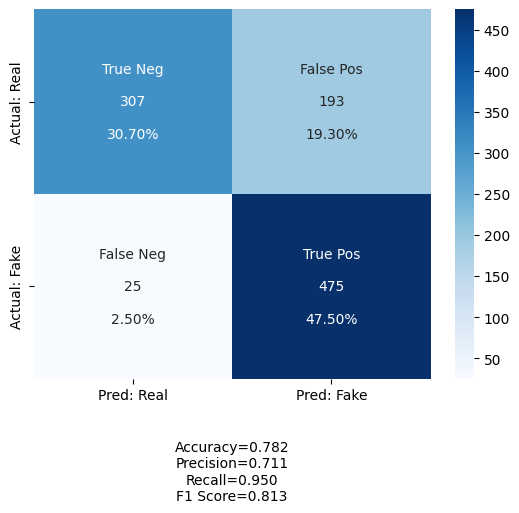

In [906]:
cm = confusion_matrix(actual, predictions)

def compute_stats(cm):
    '''confusion matrix object must be binary'''
    #Accuracy is sum of diagonal divided by total observations
    accuracy  = np.trace(cm) / float(np.sum(cm))

    #Metrics for Binary Confusion Matrices
    precision = cm[1,1] / sum(cm[:,1])
    recall    = cm[1,1] / sum(cm[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
        accuracy,precision,recall,f1_score)
        
    return stats_text

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1,v2,v3 in zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2,2)
category1 = ["Actual: Real","Actual: Fake"]
category2 = ["Pred: Real","Pred: Fake"]

sns.heatmap(cm, annot=labels, 
            fmt='', cmap='Blues', xticklabels=category2, yticklabels=category1)

plt.xlabel(compute_stats(cm))

In [907]:
correct, total

(782, 1000)

### Inference time

In [908]:
print(f"\nTime taken for inference on {test_device} device: {infer_time:.4f} seconds")
print(f"Average batch inference time on {test_device} device: {(sum(batch_timings)/len(batch_timings)):.4f} seconds")


Time taken for inference on cpu device: 10.6924 seconds
Average batch inference time on cpu device: 0.3305 seconds


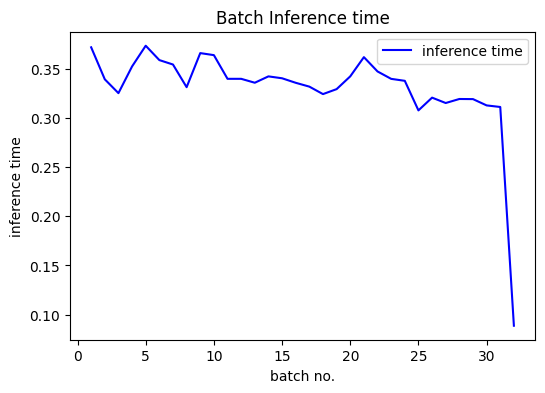

In [909]:
num_batches = range(1, len(batch_timings) + 1)

plt.figure(figsize=(6, 4))

# Plotting losses
plt.plot(num_batches, batch_timings, label='inference time', color='blue')
plt.title('Batch Inference time')
plt.xlabel('batch no.')
plt.ylabel('inference time')
plt.legend()

### Model Architecture & Summary

In [910]:
import torchinfo

torchinfo.summary(model, input_size=(batch_size, 3, SIZE, SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
EfficientNetLite                         [32, 1]                   --
├─Sequential: 1-1                        [32, 11, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 11, 112, 112]        297
│    └─BatchNorm2d: 2-2                  [32, 11, 112, 112]        22
│    └─ReLU6: 2-3                        [32, 11, 112, 112]        --
├─ModuleList: 1-2                        --                        --
│    └─ModuleList: 2-4                   --                        --
│    │    └─MBConvBlock: 3-1             [32, 13, 112, 112]        290
│    └─ModuleList: 2-5                   --                        --
│    │    └─MBConvBlock: 3-2             [32, 24, 56, 56]          2,598
│    │    └─MBConvBlock: 3-3             [32, 24, 56, 56]          6,514
│    └─ModuleList: 2-6                   --                        --
│    │    └─MBConvBlock: 3-4             [32, 38, 28, 28]          6,628
│   

In [911]:
from torchsummary import summary

if not QUANTIZE and not IS_QUANTIZED:
    summary(model, (3, SIZE, SIZE), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 11, 112, 112]             297
       BatchNorm2d-2         [32, 11, 112, 112]              22
             ReLU6-3         [32, 11, 112, 112]               0
            Conv2d-4         [32, 11, 112, 112]              99
       BatchNorm2d-5         [32, 11, 112, 112]              22
             ReLU6-6         [32, 11, 112, 112]               0
            Conv2d-7         [32, 13, 112, 112]             143
       BatchNorm2d-8         [32, 13, 112, 112]              26
       MBConvBlock-9         [32, 13, 112, 112]               0
           Conv2d-10         [32, 51, 112, 112]             663
      BatchNorm2d-11         [32, 51, 112, 112]             102
            ReLU6-12         [32, 51, 112, 112]               0
           Conv2d-13           [32, 51, 56, 56]             459
      BatchNorm2d-14           [32, 51,

## Part 9: Mobile Optimization

In [912]:
# # sample data for dummy input
# dataiter = iter(testloader)
# X, Y, labels, cats, paths = next(dataiter)

In [913]:
# from torch.utils.mobile_optimizer import optimize_for_mobile

# scripted_module = torch.jit.trace(model, X.to(device))
# # scripted_module = torch.jit.script(model)
# optimized_scripted_module = optimize_for_mobile(scripted_module)

# # using optimized lite interpreter model makes inference about 60% faster than the non-optimized lite interpreter model, which is about 6% faster than the non-optimized full jit model
# optimized_scripted_module._save_for_lite_interpreter("mobile_effnet_lite.ptl")

## Miscellaneous

### Clearing unused GPU Memory

In [914]:
# cleaning up
X = None
Y = None
out = None
logits = None
pred = None
results = None
actual = None
predictions = None
cm = None
data = None

cleanup()